This notebook visualises samples from Clevr4 and evaluates the unsupervised clustering of Clevr4 images with respect to each of the four taxonomies.

It uses faiss-gpu for fast k-means clustering, and sklearn for NMI computation

In [2]:
import torch
from matplotlib import pyplot as plt
import utils
from torchvision import transforms

import numpy as np
from sklearn.metrics import normalized_mutual_info_score

Define your local path to Clevr4 here

In [3]:
clevr_10k_path = '/PATH/TO/CLEVR4_10K/'

Class Name: metal
Class Index: 1


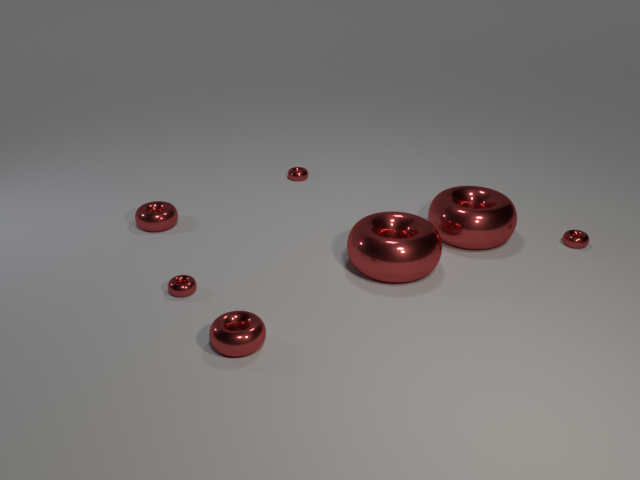

In [4]:
# Visualise sample
dataset_no_xform = utils.Clevr4(
    root=clevr_10k_path,
    taxonomy="texture",
    split="val",
)

index = 32
image, target = dataset_no_xform[index]
class_name = dataset_no_xform.all_taxonomies[dataset_no_xform.taxonomy][target]
print(f"Class Name: {class_name}")
print(f"Class Index: {target}")
image

In [5]:
# Init model
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu") 
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vitb14')
model = model.to(device)

# Define DINOv2 eval transform
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)
transform = transforms.Compose(
    [
        transforms.Resize(256, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=imagenet_mean, 
            std=imagenet_std
            )
    ]
)

# Init dataset
dataset = utils.Clevr4(
    root=clevr_10k_path,
    taxonomy="texture",
    split="val",
    transform=transform
)

Using cache found in /private/home/sgvaze/.cache/torch/hub/facebookresearch_dinov2_main
xFormers not available
xFormers not available


In [6]:
# Extract model features
features = utils.extract_features(
    model, 
    dataset, 
    batch_size=128, 
    device=device
    )

100%|██████████| 17/17 [00:18<00:00,  1.07s/it]


In [7]:
all_taxonomies = ("texture", "shape", "color", "count")

# Cluster features with k-means
preds = utils.cluster_features(
    features, 
    n_clusters=10
    )

# Measure accuracy on all taxonomie
acc_list = []
nmi_list = []

for taxonomy in all_taxonomies:

    all_targets = dataset._get_all_taxonomy_targets(taxonomy)
    all_targets = np.array(all_targets)
    acc = utils.cluster_acc(
        all_targets, 
        preds
        )
    nmi = normalized_mutual_info_score(
        all_targets,
        preds
    )

    acc_list.append(100 * acc)
    nmi_list.append(100 * nmi)
    print(f"Taxonomy: {taxonomy}")
    print(f"ACC: {100 * acc:.2f}")
    print(f"NMI: {100 * nmi:.2f}")


Clustering 2107 points in 768D to 10 clusters, redo 1 times, 25 iterations
  Preprocessing in 0.00 s
  Iteration 24 (0.11 s, search 0.03 s): objective=1.21704e+06 imbalance=1.032 nsplit=0       
Taxonomy: texture
ACC: 13.15
NMI: 1.06
Taxonomy: shape
ACC: 98.24
NMI: 96.90
Taxonomy: color
ACC: 13.00
NMI: 0.86
Taxonomy: count
ACC: 13.29
NMI: 1.26


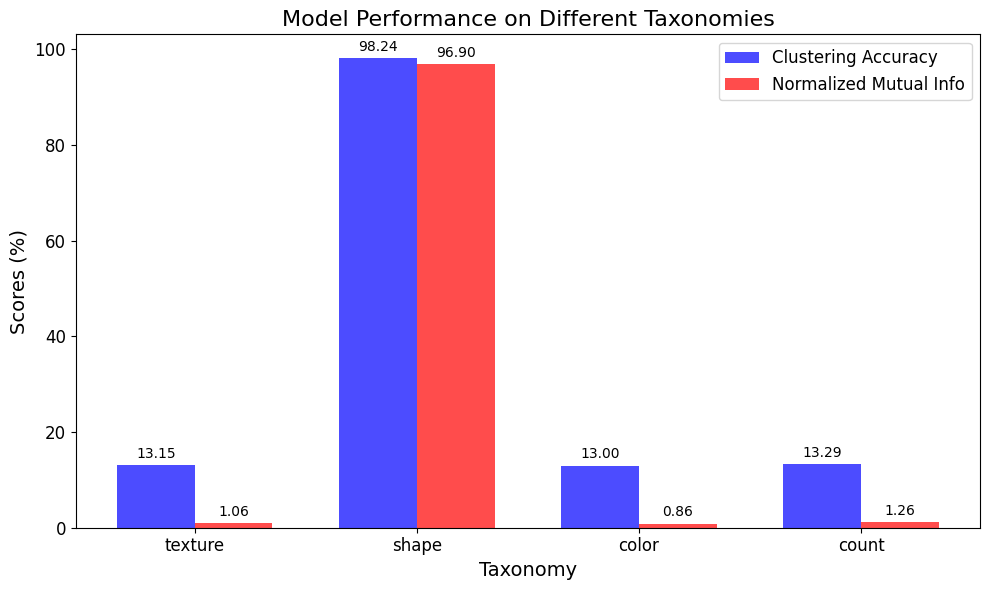

In [8]:
def plot_metrics(taxonomies, acc_list, nmi_list):
    
    x = np.arange(len(taxonomies))
    width = 0.35  # the width of the bars

    fig, ax = plt.subplots(figsize=(10, 6))
    rects1 = ax.bar(x - width/2, acc_list, width, label='Clustering Accuracy', color='blue', alpha=0.7)
    rects2 = ax.bar(x + width/2, nmi_list, width, label='Normalized Mutual Info', color='red', alpha=0.7)

    # Set the font sizes for labels, title, and ticks
    label_font_size = 14
    tick_font_size = 12
    legend_font_size = 12

    
    ax.set_xlabel('Taxonomy', fontsize=label_font_size)
    ax.set_ylabel('Scores (%)', fontsize=label_font_size)
    ax.set_title('Model Performance on Different Taxonomies', fontsize=16)
    ax.set_xticks(x)
    ax.set_xticklabels(taxonomies, fontsize=tick_font_size)
    ax.tick_params(axis='y', labelsize=tick_font_size)
    ax.legend(fontsize=legend_font_size)

    # Autolabel function to display the value on top of bars
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.annotate('{:.2f}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    autolabel(rects1)
    autolabel(rects2)

    fig.tight_layout()

    plt.show()

plot_metrics(all_taxonomies, acc_list, nmi_list)
